In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.insert(0, '/home/aew492/research-summer2020/code')
from suave import cf_model
from fourparam_fit import xi_bestfit, fit_to_cf_model

In [2]:
data_dir='/scratch/aew492/research-summer2020_output/'
ncont = 1000
rmin = 20.0
rmax = 140.0
nbins = 22

In [3]:
def compare_fits(r_avg, ls_results, rfine, fourparam_fit, rcont, bao_basis, cov_type='full', mock_name=None,
                 fourparam_alpha=None, bao_alpha=None, rmin=rmin, rmax=rmax):
    fig, ax = plt.subplots(figsize=(8,6))

    plt.plot(r_avg, ls_results, marker='o', ls='None', alpha=0.8, label=f'L-S Results')

    plt.plot(rfine, fourparam_fit, lw=2, alpha=0.8, label='standard 4-param (alpha={:.2f})'.format(fourparam_alpha))

    plt.plot(rcont, bao_basis, lw=2, alpha=0.8, label='bao iterative (alpha={:.2f})'.format(bao_alpha))

    ax.set_xlim(rmin, rmax)
    ax.set_ylim(-.01, 0.04)
    plt.axhline(0, color="k", alpha=0.5, lw=1)
    ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
    ax.set_ylabel(r'correlation function $\xi$(r)')
    ax.set_title(f'{mock_name}: {cov_type} covariance matrix')
    plt.legend()

In [4]:
def compare_bestfits(rlz, cat_tag, mock_tag, cov_type, data_dir=data_dir, m=None, b=None, ncont=ncont,
                 rmin=rmin, rmax=rmax, nbins=nbins):
    
    mock_name = f'{cat_tag}_rlz{rlz}_lognormal' if mock_tag == 'lognormal' else f'{cat_tag}_rlz{rlz}_m-{m}.000-L_b-{b}00'
    
    # Landy-Szalay
    if mock_tag == 'gradient':
        xi_ls = np.load(os.path.join(data_dir, f'gradient/1D/ls/{cat_tag}/xi_ls_3x_{mock_name}.npy'), allow_pickle=True)
    else:
        assert mock_tag == 'lognormal'
        xi_ls = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{mock_name}.npy'), allow_pickle=True)
    r_avg = xi_ls[0]
    ls_results = xi_ls[1]
    
    # 4-parameter fit
    fourparam_results = np.load(os.path.join(data_dir, f'bases/4-parameter_fit/{cov_type}/results_{mock_tag}_{cat_tag}/basis_{mock_tag}_{mock_name}.npy'), allow_pickle=True).item()
    B_sq = fourparam_results['B_sq']
    a1 = fourparam_results['a1']
    a2 = fourparam_results['a2']
    a3 = fourparam_results['a3']
    fourparam_alpha = fourparam_results['best_alpha']
    
    # plug recovered parameters back into xi equation
    rfine = np.linspace(rmin, rmax, ncont+1)
    xi_mod_fine = cf_model(fourparam_alpha*rfine, cosmo_base=None, redshift=0.57, bias=2.0)

    fourparam_fit = xi_bestfit(rfine, xi_mod_fine, B_sq, a1, a2, a3)
    
    # bao iterative
    bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_{mock_tag}_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{mock_name}.npy'), allow_pickle=True)
    rcont, bao_basis, _, _, extra_dict = bao_results
    bao_alpha = extra_dict['alpha_model']
    
    compare_fits(r_avg, ls_results, rfine, fourparam_fit, rcont, bao_basis, cov_type, mock_name, fourparam_alpha, bao_alpha)
    

In [5]:
cat_tag = 'L750_n1e-4_z057_patchy_As2x'

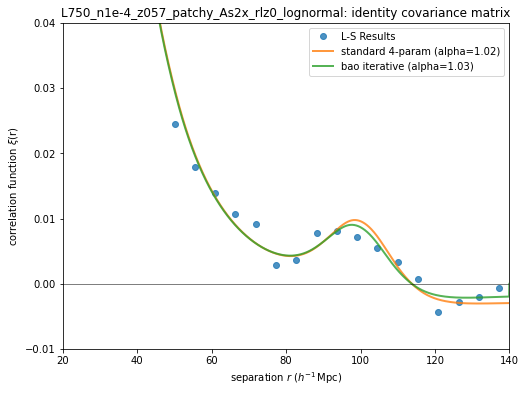

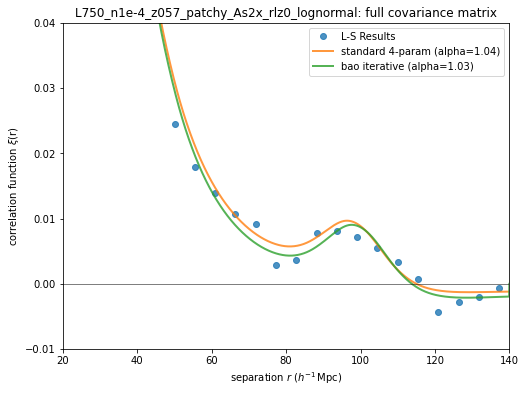

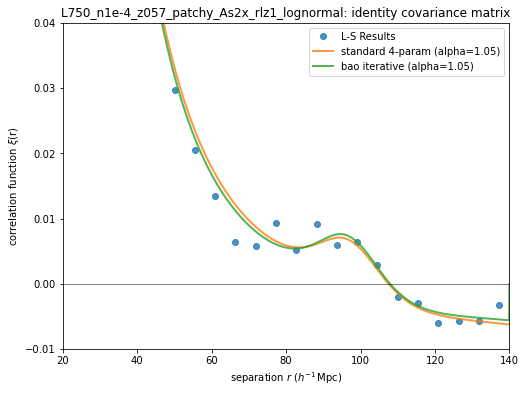

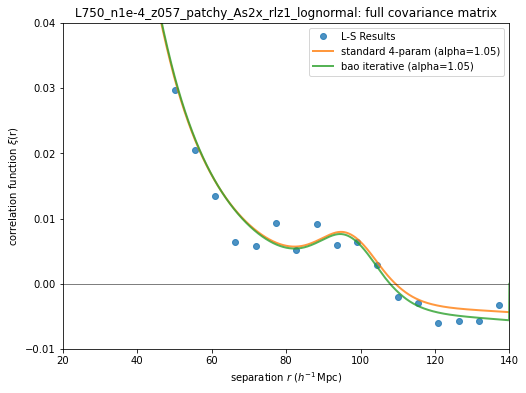

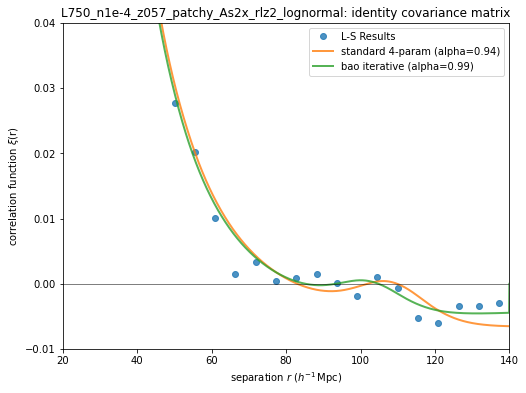

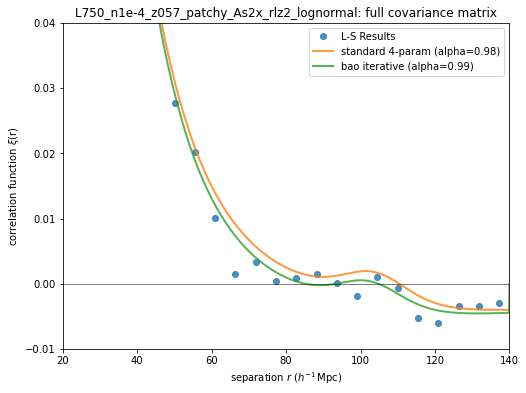

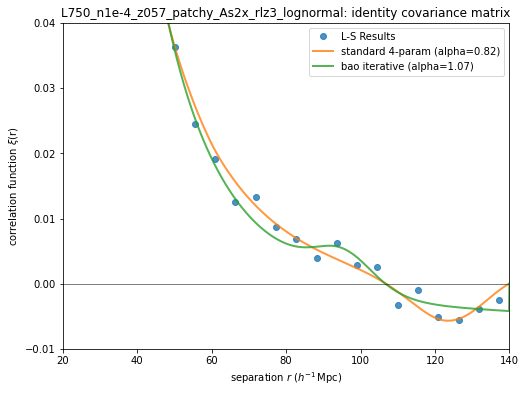

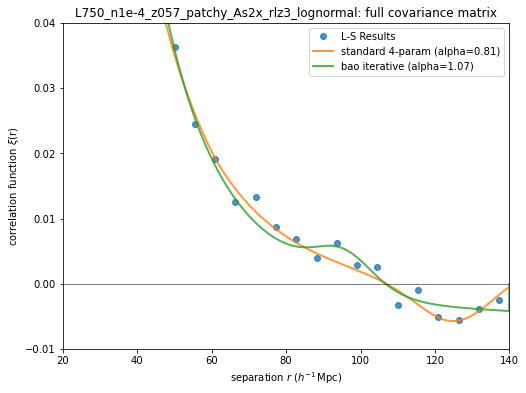

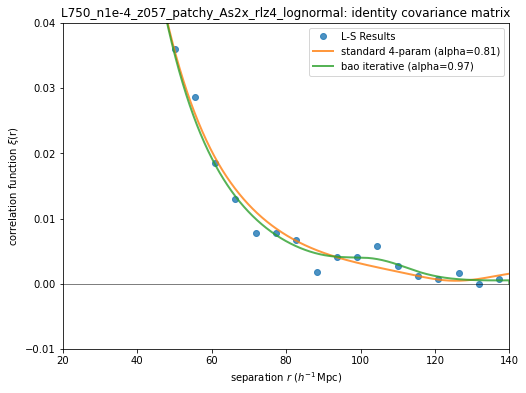

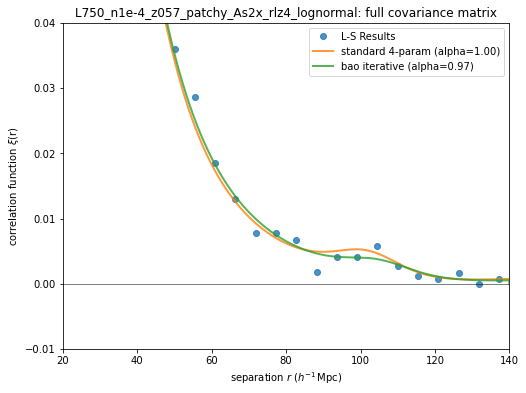

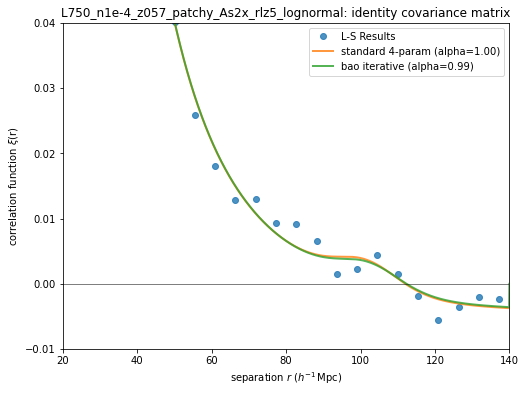

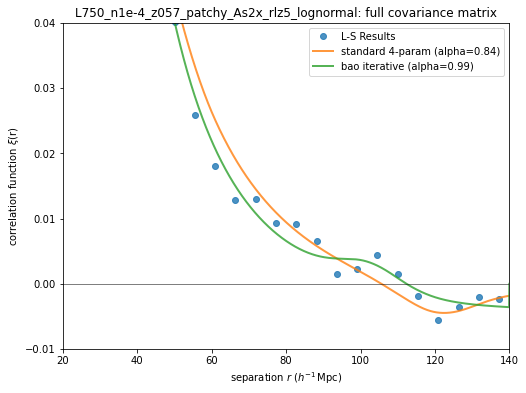

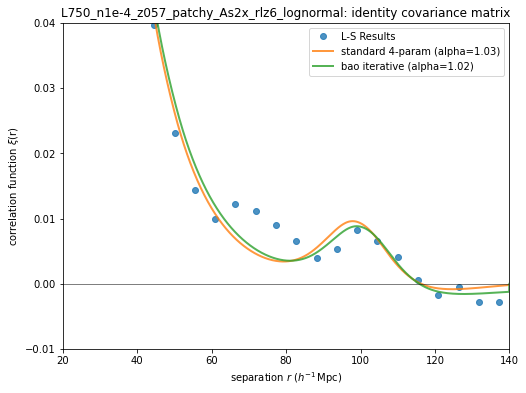

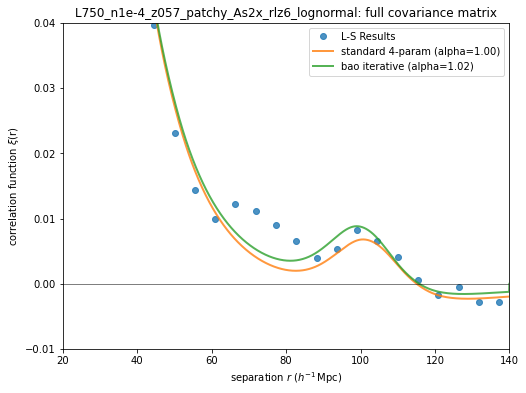

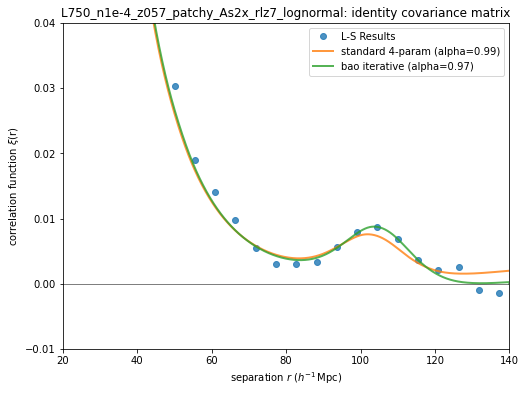

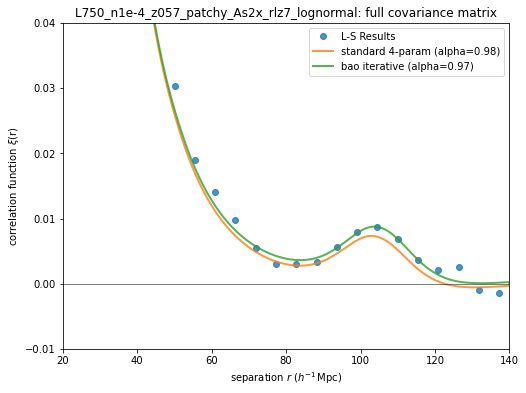

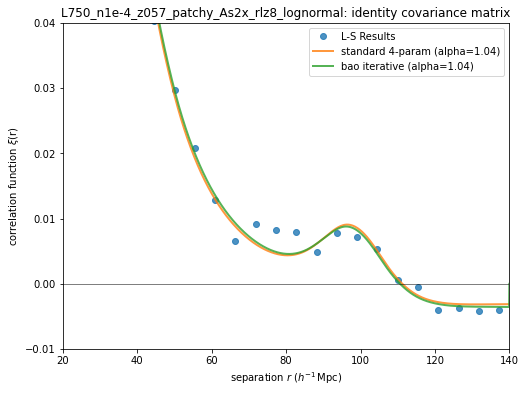

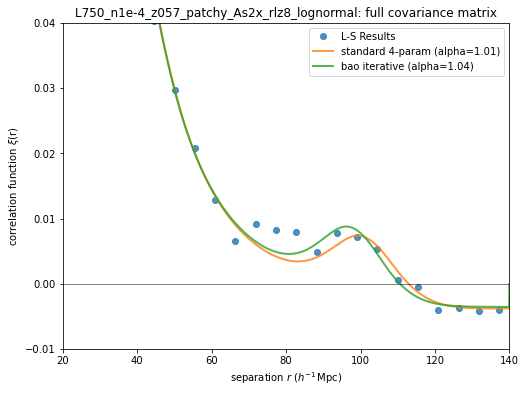

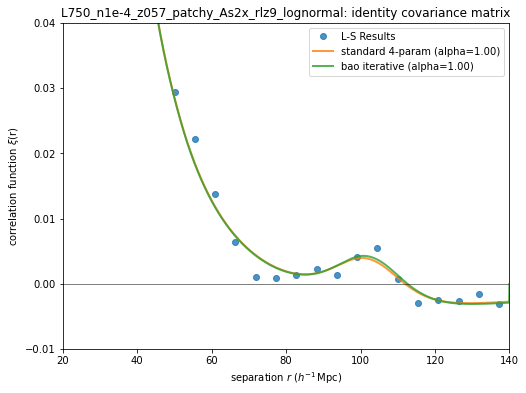

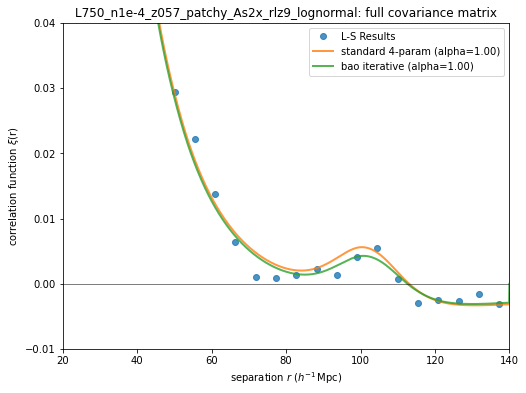

In [6]:
for rlz in range(10):
    compare_bestfits(rlz, cat_tag, mock_tag='lognormal', cov_type='identity')
    compare_bestfits(rlz, cat_tag, mock_tag='lognormal', cov_type='full')

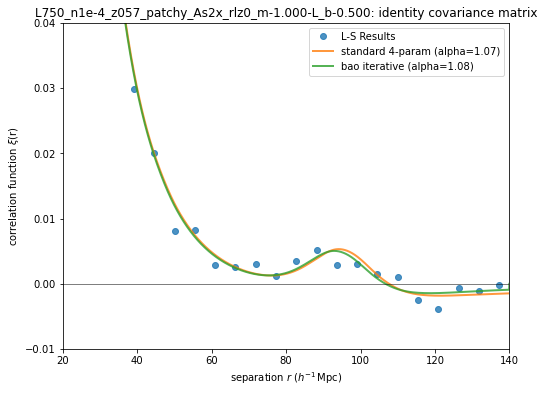

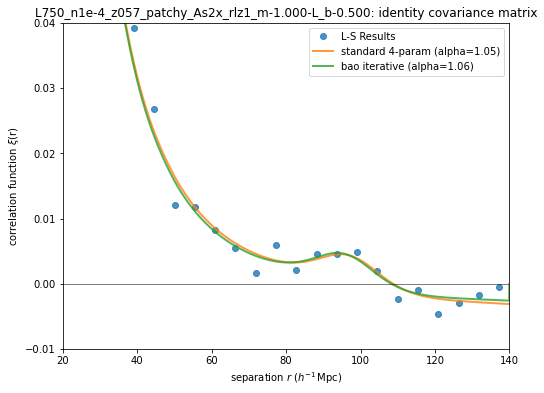

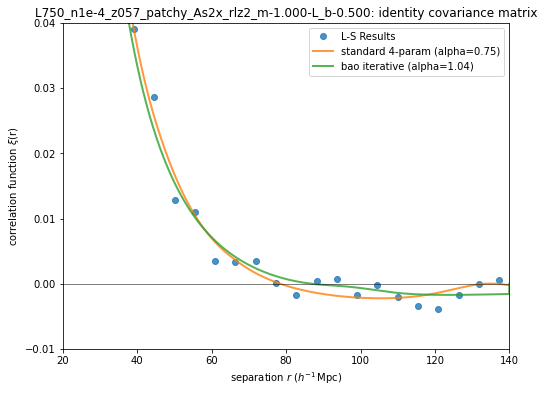

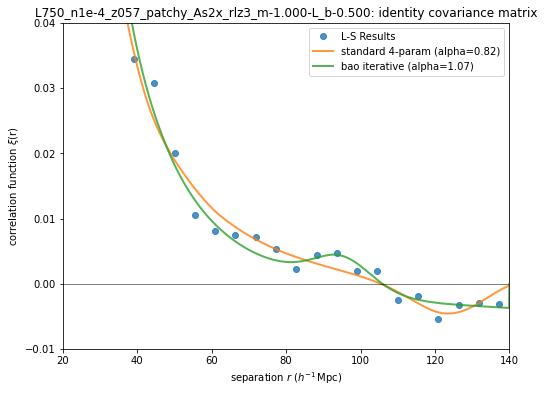

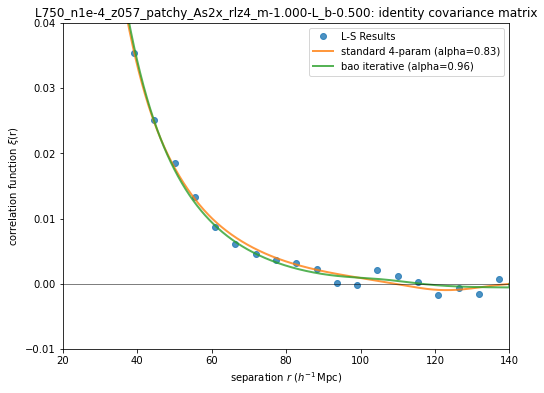

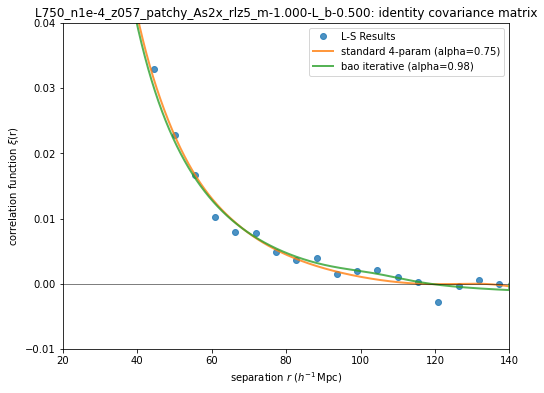

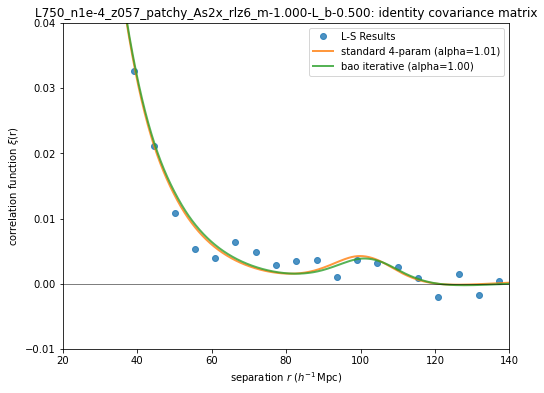

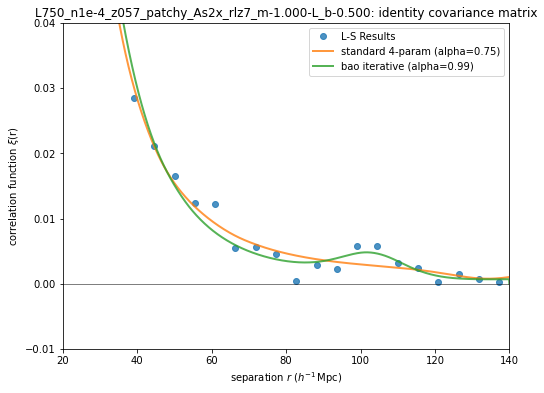

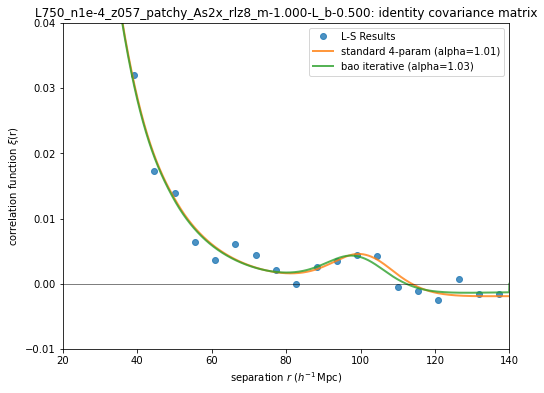

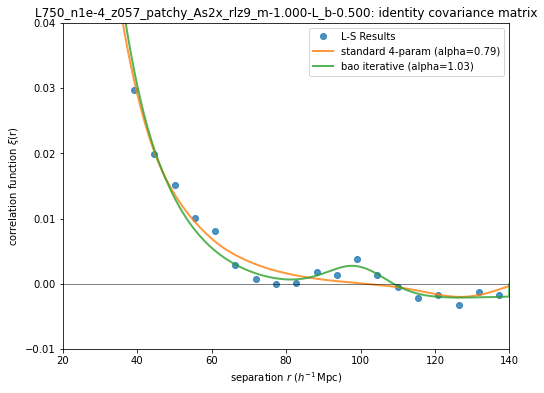

In [7]:
for rlz in range(10):
    compare_bestfits(rlz, cat_tag, mock_tag='gradient', cov_type='identity', m=1, b=0.5)

### checking out particularly bad fit

In [8]:
# lognormal, rlz 4
rlz = 4
compare_bestfits(rlz, cat_tag, mock_tag='lognormal')

TypeError: compare_bestfits() missing 1 required positional argument: 'cov_type'

In [ ]:
# see if the script is choosing the wrong 'best' alpha; let's look at fits with different alphas

In [ ]:
alpha = 0.97

In [ ]:
# load in data
mock_name = f'{cat_tag}_rlz{rlz}_lognormal'
xi_results = np.load(os.path.join(data_dir, f'lognormal/xi/ls/{cat_tag}/xi_ls_3x_{mock_name}.npy'), allow_pickle=True)
r_avg = xi_results[0]
xi_ls = xi_results[1]

# covariance matrix (identity for now)
C_inv = np.identity(len(r_avg))

In [ ]:
xi_fit, M = fit_to_cf_model(alpha, xi_ls, r_avg, C_inv)
B_sq, a1, a2, a3 = M

In [ ]:
# plug recovered parameters back into xi equation
rfine = np.linspace(rmin, rmax, ncont+1)
xi_mod_fine = cf_model(alpha*rfine, cosmo_base=None, redshift=0.57, bias=2.0)

fourparam_fit = xi_bestfit(rfine, xi_mod_fine, B_sq, a1, a2, a3)

In [ ]:
# bao iterative
bao_results = np.load(os.path.join(data_dir, f'bases/bao_iterative/results/results_lognormal_{cat_tag}/converged/cf_baoiter_cosmoplanck15_test_trrnum_3x_{mock_name}.npy'), allow_pickle=True)
rcont, bao_basis, _, _, extra_dict = bao_results
bao_alpha = extra_dict['alpha_model']

In [ ]:
compare_fits(r_avg, xi_ls, rfine, fourparam_fit, rcont, bao_basis, mock_name, alpha, alpha)